<hr>

## <h3 align="center"> Mini Projet Spark <h3/>

<p>


Réalisé par : Miracle VODOUMBO et Dhalil BELLO




## Objectif du projet
L'objectif de ce projet est de charger, traiter et analyser les données sur le prix des carburants en France avec Spark.


## Données
Données sur les prix des carburants de 2019 à 2023 depuis le dépôt Github (https://github.com/rvm-courses/GasPrices)


## Étapes du Notebook


1.   Collecte des données
2.   Préparation des données
3.   Visualisation des variations des prix des carburants
4.   Modélisation de l’évolution des prix






## 1.   Configuration et chargement des fichiers de données

In [ ]:
# Montage du lecteur Google Drive dans l'environnement Colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Liste des fichiers dans le répertoire
!ls "/content/drive/MyDrive/Big_Data"

 Big_Data_Project.ipynb					  Prix2019.csv.gz
'Copie de Big_Data_Script.ipynb'			  Prix2020.csv.gz
'Mag 3 - Projet Big data - Pyspark - 2023-2024 (1).pdf'   Prix2021.csv.gz


In [ ]:
# Filtrage des fichiers avec l'extension '.csv.gz'
import os

chemin_repertoire = "/content/drive/MyDrive/Big_Data"

fichiers_du_repertoire = os.listdir(chemin_repertoire)

fichiers_csv_gz = [fichier for fichier in fichiers_du_repertoire if fichier.endswith('.csv.gz')]

fichiers_csv_gz


['Prix2019.csv.gz', 'Prix2020.csv.gz', 'Prix2021.csv.gz']

## 2.   Préparation des données

###    Étape 1 : Préparation des données avec PySpark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=b201222024492a817a502bcb307d89fabe9d4a8bf15af4c8ae245ecc78d2c9c8
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Création d'une session Spark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("example") \
    .config("spark.driver.memory", "15g") \
    .config("spark.executor.memory", "15g") \
    .getOrCreate()

In [ ]:
# Liste des fichiers à lire
fichiers_csv_gz = ['/content/drive/MyDrive/Big_Data/Prix2019.csv.gz',
                   '/content/drive/MyDrive/Big_Data/Prix2020.csv.gz',
                   '/content/drive/MyDrive/Big_Data/Prix2021.csv.gz']

list_df_spark = []

# Lecture des fichiers en DataFrame Spark
for fichier in fichiers_csv_gz:
    df_spark = spark.read.csv(fichier, header=False, sep=';', inferSchema=True)
    list_df_spark.append(df_spark)

# Union des DataFrames en un seul DataFrame Spark
price_data_spark = list_df_spark[0]
for df_spark in list_df_spark[1:]:
    price_data_spark = price_data_spark.union(df_spark)

# Renommage des colonnes
price_data_spark = price_data_spark.toDF('id_pdv', 'cp', 'pop', 'latitude', 'longitude', 'date', 'id_carburant', 'gas_label', 'prix')
price_data_spark.show()

+-------+----+---+---------+---------+-------------------+------------+---------+----+
| id_pdv|  cp|pop| latitude|longitude|               date|id_carburant|gas_label|prix|
+-------+----+---+---------+---------+-------------------+------------+---------+----+
|1000001|1000|  R|4620114.0| 519791.0|2019-01-04 10:53:48|           1|   Gazole|1328|
|1000001|1000|  R|4620114.0| 519791.0|2019-01-07 10:25:25|           1|   Gazole|1348|
|1000001|1000|  R|4620114.0| 519791.0|2019-01-10 08:54:28|           1|   Gazole|1374|
|1000001|1000|  R|4620114.0| 519791.0|2019-01-11 10:01:54|           1|   Gazole|1387|
|1000001|1000|  R|4620114.0| 519791.0|2019-01-14 11:04:53|           1|   Gazole|1394|
|1000001|1000|  R|4620114.0| 519791.0|2019-01-16 10:21:21|           1|   Gazole|1394|
|1000001|1000|  R|4620114.0| 519791.0|2019-01-17 08:30:12|           1|   Gazole|1391|
|1000001|1000|  R|4620114.0| 519791.0|2019-01-18 10:08:25|           1|   Gazole|1401|
|1000001|1000|  R|4620114.0| 519791.0|2019-

In [ ]:
# Affichage du nombre de ligne et de colonne
nombre_de_lignes = price_data_spark.count()
nombre_de_colonnes = len(price_data_spark.columns)

print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

Nombre de lignes : 12365616
Nombre de colonnes : 9


In [ ]:
# Affichage du nombre de valeurs manquantes par colonnes
from pyspark.sql.functions import col, sum as spark_sum
nan_counts = price_data_spark.agg(*[
    (spark_sum(col(c).isNull().cast("int"))).alias(c)
    for c in price_data_spark.columns
])

nan_counts.show()

+------+---+---+--------+---------+-----+------------+---------+-----+
|id_pdv| cp|pop|latitude|longitude| date|id_carburant|gas_label| prix|
+------+---+---+--------+---------+-----+------------+---------+-----+
|     0|  0|  0|     203|      200|10560|       10560|    10560|10560|
+------+---+---+--------+---------+-----+------------+---------+-----+



In [ ]:
# Suppression des lignes où gas_label est nulle
price_data_spark = price_data_spark.na.drop(subset=["gas_label"])

In [ ]:
nombre_de_lignes = price_data_spark.count()
nombre_de_colonnes = len(price_data_spark.columns)

print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

Nombre de lignes : 12355056
Nombre de colonnes : 9


In [ ]:
# Changement de l'ordre des colonnes
order = ['date', 'id_carburant', 'gas_label', 'prix', 'id_pdv', 'cp', 'pop', 'latitude', 'longitude']
price_data_spark = price_data_spark.select(*order)
price_data_spark.show()

+-------------------+------------+---------+----+-------+----+---+---------+---------+
|               date|id_carburant|gas_label|prix| id_pdv|  cp|pop| latitude|longitude|
+-------------------+------------+---------+----+-------+----+---+---------+---------+
|2019-01-04 10:53:48|           1|   Gazole|1328|1000001|1000|  R|4620114.0| 519791.0|
|2019-01-07 10:25:25|           1|   Gazole|1348|1000001|1000|  R|4620114.0| 519791.0|
|2019-01-10 08:54:28|           1|   Gazole|1374|1000001|1000|  R|4620114.0| 519791.0|
|2019-01-11 10:01:54|           1|   Gazole|1387|1000001|1000|  R|4620114.0| 519791.0|
|2019-01-14 11:04:53|           1|   Gazole|1394|1000001|1000|  R|4620114.0| 519791.0|
|2019-01-16 10:21:21|           1|   Gazole|1394|1000001|1000|  R|4620114.0| 519791.0|
|2019-01-17 08:30:12|           1|   Gazole|1391|1000001|1000|  R|4620114.0| 519791.0|
|2019-01-18 10:08:25|           1|   Gazole|1401|1000001|1000|  R|4620114.0| 519791.0|
|2019-01-21 10:30:12|           1|   Gazole

In [ ]:
from pyspark.sql.functions import col, year, month, weekofyear
from pyspark.sql.types import TimestampType

# Conversion de la colonne 'date' en format Timestamp
price_data_spark = price_data_spark.withColumn('date', col('date').cast(TimestampType()))

# Extraction des informations sur l'année, le mois et la semaine de la colonne 'date'
price_data_spark = price_data_spark.withColumn('annee', year('date'))
price_data_spark = price_data_spark.withColumn('mois', month('date'))
price_data_spark = price_data_spark.withColumn('semaine', weekofyear('date'))

price_data_spark.show()

+-------------------+------------+---------+----+-------+----+---+---------+---------+-----+----+-------+
|               date|id_carburant|gas_label|prix| id_pdv|  cp|pop| latitude|longitude|annee|mois|semaine|
+-------------------+------------+---------+----+-------+----+---+---------+---------+-----+----+-------+
|2019-01-04 10:53:48|           1|   Gazole|1328|1000001|1000|  R|4620114.0| 519791.0| 2019|   1|      1|
|2019-01-07 10:25:25|           1|   Gazole|1348|1000001|1000|  R|4620114.0| 519791.0| 2019|   1|      2|
|2019-01-10 08:54:28|           1|   Gazole|1374|1000001|1000|  R|4620114.0| 519791.0| 2019|   1|      2|
|2019-01-11 10:01:54|           1|   Gazole|1387|1000001|1000|  R|4620114.0| 519791.0| 2019|   1|      2|
|2019-01-14 11:04:53|           1|   Gazole|1394|1000001|1000|  R|4620114.0| 519791.0| 2019|   1|      3|
|2019-01-16 10:21:21|           1|   Gazole|1394|1000001|1000|  R|4620114.0| 519791.0| 2019|   1|      3|
|2019-01-17 08:30:12|           1|   Gazole|13

In [ ]:
# Extraire la date en utilisant la fonction "cast"
price_data_spark = price_data_spark.withColumn("days", col("date").cast("date"))

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Trie des données par date, type de carburant, et station
price_data_spark = price_data_spark.sort("days", "id_carburant", "id_pdv")

# Fenêtre partitionnée par type de carburant et station, ordonnée par date
windowSpec = Window().partitionBy("id_carburant", "id_pdv").orderBy("days")

# Décalage d'une période pour obtenir le prix de la veille
price_data_spark = price_data_spark.withColumn("lag_price", F.lag("prix").over(windowSpec))

price_data_spark.show()

+-------------------+------------+---------+----+-------+----+---+---------+---------+-----+----+-------+----------+---------+
|               date|id_carburant|gas_label|prix| id_pdv|  cp|pop| latitude|longitude|annee|mois|semaine|      days|lag_price|
+-------------------+------------+---------+----+-------+----+---+---------+---------+-----+----+-------+----------+---------+
|2019-01-04 20:00:00|           1|   Gazole|1440|1000004|1000|  R|4618800.0| 524500.0| 2019|   1|      1|2019-01-04|     NULL|
|2019-01-08 20:00:00|           1|   Gazole|1480|1000004|1000|  R|4618800.0| 524500.0| 2019|   1|      2|2019-01-08|     1440|
|2019-01-11 20:00:00|           1|   Gazole|1510|1000004|1000|  R|4618800.0| 524500.0| 2019|   1|      2|2019-01-11|     1480|
|2019-01-16 18:26:32|           1|   Gazole|1520|1000004|1000|  R|4618800.0| 524500.0| 2019|   1|      3|2019-01-16|     1510|
|2019-02-06 20:00:00|           1|   Gazole|1540|1000004|1000|  R|4618800.0| 524500.0| 2019|   2|      6|2019-0

In [ ]:
from pyspark.sql.functions import col

# Affichage du tableau d'effectif par type de carburant
effectif_par_gas = price_data_spark.groupBy("gas_label").count()
effectif_par_gas.show()

+---------+-------+
|gas_label|  count|
+---------+-------+
|      E10|3139349|
|     SP98|3226339|
|      E85| 721506|
|   Gazole|3758684|
|     SP95| 957665|
|     GPLc| 551513|
+---------+-------+



In [ ]:
# Pie Chart de la distribution des types de carburant

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import plotly.graph_objects as go

effectif_par_gas_pandas = effectif_par_gas.toPandas()

# Palette de couleurs
color_list = ['purple', 'green', 'blue', 'orange', 'pink', 'yellow']

# Comptages pour chaque catégorie
labels = effectif_par_gas_pandas['gas_label'].tolist()
values = effectif_par_gas_pandas['count'].tolist()

# Pie chart
pie_chart = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.6,
    marker=dict(colors=color_list, line=dict(color='white', width=3)),
    textposition='inside',
    textinfo='percent+label',
)])

# Mettre à jour la mise en page
pie_chart.update_layout(
    title='Distribution of Gas Labels',
    showlegend=False,
    height=400,
    width=500,
)

L'observation de la distribution des différents type de carburant fait ressortir que les carburants GPLc et E85 avec leurs proportions respectives de 4.46% et 5.84% sont très sous représentés dans notre population. Ils présentent donc un faible intérêt et seront supprimés pour la suite des analyses.

In [ ]:
price_data_spark = price_data_spark.filter(~price_data_spark["gas_label"].isin("GPLc", "E85"))

###    Étape 2 : Ajout des variables calculées "Price Index" et "Index de la semaine" au dataframe.

In [ ]:
from pyspark.sql.functions import avg

# Calcul du prix moyen journalier
average_price_france  = price_data_spark.groupBy("days", "id_carburant").agg(avg("prix").alias("prix_moyen"))
average_price_france = average_price_france.orderBy("days","id_carburant")
average_price_france.show()

# Jointure sur les colonnes 'days' et 'id_carburant'
price_data = price_data_spark.join(average_price_france, on=["days", "id_carburant"], how='left')
price_data = price_data.orderBy("date", "id_carburant")
price_data.show()

+----------+------------+------------------+
|      days|id_carburant|        prix_moyen|
+----------+------------+------------------+
|2019-01-01|           1|1424.2279582366589|
|2019-01-01|           2|1493.2641509433963|
|2019-01-01|           5|1410.8494368701838|
|2019-01-01|           6|1507.4599348534202|
|2019-01-02|           1|1394.9234472797305|
|2019-01-02|           2|1415.7704507512522|
|2019-01-02|           5|1389.7919927754365|
|2019-01-02|           6|1478.8105906313647|
|2019-01-03|           1| 1395.504732607667|
|2019-01-03|           2|1416.3697694278394|
|2019-01-03|           5|1392.3583937198068|
|2019-01-03|           6|1480.3267037145365|
|2019-01-04|           1|1386.5670557146002|
|2019-01-04|           2|1415.8170019467877|
|2019-01-04|           5|1384.9245541838134|
|2019-01-04|           6|1474.1281167108752|
|2019-01-05|           1|1393.2947647951441|
|2019-01-05|           2|1412.8492647058824|
|2019-01-05|           5|1401.2511693171189|
|2019-01-0

In [ ]:
# Création la colonne index_prix en utilisant la formule spécifiée
price_data = price_data.withColumn(
    "index_prix",
    (((col("prix") - col("prix_moyen")) / col("prix_moyen")) + 1) * 100
)

price_data.show()

+----------+------------+-------------------+---------+----+--------+-----+---+--------------+----------------+-----+----+-------+---------+------------------+------------------+
|      days|id_carburant|               date|gas_label|prix|  id_pdv|   cp|pop|      latitude|       longitude|annee|mois|semaine|lag_price|        prix_moyen|        index_prix|
+----------+------------+-------------------+---------+----+--------+-----+---+--------------+----------------+-----+----+-------+---------+------------------+------------------+
|2019-01-01|           1|2019-01-01 00:00:00|   Gazole|1314|76320002|76320|  R|     4929000.0|        104000.0| 2019|   1|      1|     NULL|1424.2279582366589| 92.26051155651147|
|2019-01-01|           1|2019-01-01 00:00:00|   Gazole|1408|10430002|10430|  R|     4826416.0|        407043.0| 2019|   1|      1|     NULL|1424.2279582366589| 98.86057859327865|
|2019-01-01|           1|2019-01-01 00:00:00|   Gazole|1467|38260004|38260|  R|     4535200.0|        525

In [ ]:
# Création de la colonne index_semaine

from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Fenêtre triée par année et semaine
window_spec = Window.orderBy("annee", "semaine")

# Ajout de la colonne 'index_semaine' en fonction des conditions
price_data = (
    price_data
    .withColumn('index_semaine',
                F.when(F.col('annee') == 2019, F.col('semaine'))
                .when(F.col('annee') == 2020, F.col('semaine') + 52)
                .otherwise(F.col('semaine') + 104)
               )
)

price_data.show()


+----------+------------+-------------------+---------+----+--------+-----+---+---------------+---------------+-----+----+-------+---------+------------------+------------------+-------------+
|      days|id_carburant|               date|gas_label|prix|  id_pdv|   cp|pop|       latitude|      longitude|annee|mois|semaine|lag_price|        prix_moyen|        index_prix|index_semaine|
+----------+------------+-------------------+---------+----+--------+-----+---+---------------+---------------+-----+----+-------+---------+------------------+------------------+-------------+
|2019-01-01|           1|2019-01-01 00:00:00|   Gazole|1314|76320002|76320|  R|      4929000.0|       104000.0| 2019|   1|      1|     NULL|1424.2279582366589| 92.26051155651147|            1|
|2019-01-01|           1|2019-01-01 00:00:00|   Gazole|1467|38260004|38260|  R|      4535200.0|       525400.0| 2019|   1|      1|     NULL|1424.2279582366589|103.00317386103677|            1|
|2019-01-01|           1|2019-01-01

In [ ]:
# Vérification du nombre de modalités différentes dans la colonne 'index_semaine'
distinct_count = price_data.select("index_semaine").distinct().count()
print(f"Nombre de modalités différentes dans 'index_semaine': {distinct_count}")


Nombre de modalités différentes dans 'index_semaine': 157


## 3.     Visualisation des variations des prix des carburants

### Visualisation 1 : Evolution hebdomadaire du prix moyen des carburants

In [ ]:
# Affichage des prix moyens hebdomadaire par gas_label

prix_moyen_hebdo_table = price_data.groupBy("index_semaine", "gas_label").agg(avg("prix").alias("prix_moyen_hebdomadaire"))
prix_moyen_hebdo_table = prix_moyen_hebdo_table.orderBy("index_semaine", "gas_label")
prix_moyen_hebdo_table.show()


+-------------+---------+-----------------------+
|index_semaine|gas_label|prix_moyen_hebdomadaire|
+-------------+---------+-----------------------+
|            1|      E10|     1431.2172373081464|
|            1|   Gazole|     1424.7996734815035|
|            1|     SP95|     1455.3585618354784|
|            1|     SP98|     1518.4946303919814|
|            2|      E10|     1401.5876641651032|
|            2|   Gazole|     1399.0902171155171|
|            2|     SP95|     1424.3998979201224|
|            2|     SP98|      1487.122976465787|
|            3|      E10|     1414.5244974007453|
|            3|   Gazole|     1417.6400794367214|
|            3|     SP95|      1437.689259207394|
|            3|     SP98|     1498.4357603605197|
|            4|      E10|     1423.7141221175368|
|            4|   Gazole|      1430.798795278137|
|            4|     SP95|      1443.903464947623|
|            4|     SP98|     1507.8204912350202|
|            5|      E10|     1423.0968766543144|


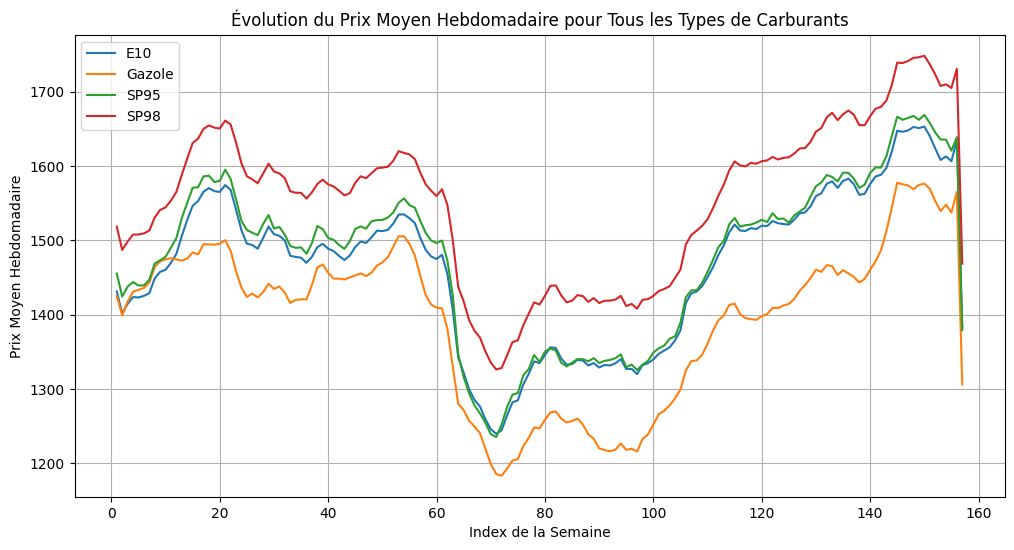

In [ ]:
# Visualisation de l'évolution du prix moyen hebdomadaire
import matplotlib.pyplot as plt
import pandas as pd

prix_moyen_hebdo_pandas = prix_moyen_hebdo_table.toPandas()

plt.figure(figsize=(12, 6))

# Boucle sur tous les types de carburants
for gas_label in prix_moyen_hebdo_pandas['gas_label'].unique():
    subset = prix_moyen_hebdo_pandas[prix_moyen_hebdo_pandas['gas_label'] == gas_label]
    plt.plot(subset['index_semaine'], subset['prix_moyen_hebdomadaire'], label=gas_label)

plt.title('Évolution du Prix Moyen Hebdomadaire pour Tous les Types de Carburants')
plt.xlabel('Index de la Semaine')
plt.ylabel('Prix Moyen Hebdomadaire')
plt.legend()
plt.grid(True)
plt.show()


L'observation du graphique fait ressortir que le gazoile est le carburant dont le prix moyen hebdomadaire est le moins élevé sur toute la période pendant que le SP98 est celui dont le prix moyen hebdomadaire est le plus élevé. On observe également une chute générale du prix moyen à partir de la 62ème semaine qui se prolonge jusqu'à la 67ème semaine faisant atteindre un pic minimal à tous les prix. On note par la suite une croissance globale de tous les prix.

### Visualisation 2 : Carte de France avec le prix moyen agrégé par département pour chaque type de carburant

In [ ]:
# Création du dataframe pour la visualisation
gazole_price_data = price_data.orderBy("date").filter(F.col('gas_label') == "Gazole")

gazole_price_data.show()

+----------+------------+-------------------+---------+----+--------+-----+---+---------------+----------------+-----+----+-------+---------+------------------+------------------+-------------+
|      days|id_carburant|               date|gas_label|prix|  id_pdv|   cp|pop|       latitude|       longitude|annee|mois|semaine|lag_price|        prix_moyen|        index_prix|index_semaine|
+----------+------------+-------------------+---------+----+--------+-----+---+---------------+----------------+-----+----+-------+---------+------------------+------------------+-------------+
|2019-01-01|           1|2019-01-01 00:00:00|   Gazole|1314|76320002|76320|  R|      4929000.0|        104000.0| 2019|   1|      1|     NULL|1424.2279582366589| 92.26051155651147|            1|
|2019-01-01|           1|2019-01-01 00:00:00|   Gazole|1467|38260004|38260|  R|      4535200.0|        525400.0| 2019|   1|      1|     NULL|1424.2279582366589|103.00317386103677|            1|
|2019-01-01|           1|2019-

In [ ]:
for col_name, col_type in gazole_price_data.dtypes:
    print(f"Colonne : {col_name}, Type : {col_type}")


Colonne : days, Type : date
Colonne : id_carburant, Type : int
Colonne : date, Type : timestamp
Colonne : gas_label, Type : string
Colonne : prix, Type : int
Colonne : id_pdv, Type : int
Colonne : cp, Type : int
Colonne : pop, Type : string
Colonne : latitude, Type : double
Colonne : longitude, Type : double
Colonne : annee, Type : int
Colonne : mois, Type : int
Colonne : semaine, Type : int
Colonne : lag_price, Type : int
Colonne : prix_moyen, Type : double
Colonne : index_prix, Type : double
Colonne : index_semaine, Type : int


In [ ]:
# Création et ajout d'une variable département au dataframe
from pyspark.sql.functions import expr, when

gazole_price_data = gazole_price_data.withColumn(
    'code_departement',
    when(
        expr("length(cp) == 5"),
        expr("substring(cp, 1, 2)")
    ).otherwise(
        expr("lpad(substring(cp, 1, 1), 2, '0')")
    )
)

gazole_price_data.show()

+----------+------------+-------------------+---------+----+--------+-----+---+-------------+---------------+-----+----+-------+---------+------------------+------------------+-------------+----------------+
|      days|id_carburant|               date|gas_label|prix|  id_pdv|   cp|pop|     latitude|      longitude|annee|mois|semaine|lag_price|        prix_moyen|        index_prix|index_semaine|code_departement|
+----------+------------+-------------------+---------+----+--------+-----+---+-------------+---------------+-----+----+-------+---------+------------------+------------------+-------------+----------------+
|2019-01-01|           1|2019-01-01 00:00:00|   Gazole|1314|76320002|76320|  R|    4929000.0|       104000.0| 2019|   1|      1|     NULL|1424.2279582366589| 92.26051155651147|            1|              76|
|2019-01-01|           1|2019-01-01 00:00:00|   Gazole|1467|38260004|38260|  R|    4535200.0|       525400.0| 2019|   1|      1|     NULL|1424.2279582366589|103.0031738

In [ ]:
# Calcul du prix moyen agrégé par département

from pyspark.sql.functions import first
gazole_price_data_mean_dep = gazole_price_data.groupBy("code_departement").agg(avg("prix").alias("Prix_moyen_departement"))


In [ ]:
from pyspark.sql.functions import first
gazole_price_data_mean_dep = gazole_price_data.groupBy("code_departement").agg(avg("prix").alias("Prix_moyen_departement"),
                                                                          first("latitude").alias("latitude_departement"),
                                                                          first("longitude").alias("longitude_departement"))


In [ ]:
gazole_price_data_mean_dep = gazole_price_data_mean_dep.orderBy("code_departement")

gazole_price_data_mean_dep.show()

+----------------+----------------------+--------------------+---------------------+
|code_departement|Prix_moyen_departement|latitude_departement|longitude_departement|
+----------------+----------------------+--------------------+---------------------+
|              01|    1413.1379237900155|       4619851.83794|        524350.637881|
|              02|    1389.2476804475373|       4938135.44743|        330178.391501|
|              03|    1393.1966611984947|           4634500.0|             261900.0|
|              04|    1429.4869789798408|           4408800.0|             600900.0|
|              05|    1400.0355499413515|           4454476.0|             627968.0|
|              06|    1426.4693485640657|           4370700.0|             729200.0|
|              07|    1388.5436270316509|       4463202.17749|        437986.312289|
|              08|    1404.8339993339994|           4974116.0|             472585.0|
|              09|    1379.7608770917484|     4294772.8869164|   

In [ ]:
gazole_price_data_mean_dep = gazole_price_data_mean_dep.withColumn(
    "latitude",
    (col("latitude_departement")/100000))

gazole_price_data_mean_dep = gazole_price_data_mean_dep.withColumn(
    "longitude",
    (col("longitude_departement")/100000))

gazole_price_data_mean_dep.show()

+----------------+----------------------+--------------------+---------------------+------------------+-------------------+
|code_departement|Prix_moyen_departement|latitude_departement|longitude_departement|          latitude|          longitude|
+----------------+----------------------+--------------------+---------------------+------------------+-------------------+
|              01|    1413.1379237900155|       4619851.83794|        524350.637881|     46.1985183794|  5.243506378809999|
|              02|    1389.2476804475373|       4938135.44743|        330178.391501|     49.3813544743| 3.3017839150099997|
|              03|    1393.1966611984947|           4634500.0|             261900.0|            46.345|              2.619|
|              04|    1429.4869789798408|           4408800.0|             600900.0|            44.088|              6.009|
|              05|    1400.0355499413515|           4454476.0|             627968.0|          44.54476|            6.27968|
|       

In [ ]:
import folium
# Coordonnées du centre de la France
latitude = 46.227638
longitude = 2.213749

# Carte de France avec folium
france_map = folium.Map(location=[latitude, longitude], width="%100", height="%100", zoom_start=6)
france_map




In [ ]:
gazole_price_data_mean_dep = gazole_price_data_mean_dep.toPandas()

In [ ]:


#Affichage des données
for i in range(0,len(gazole_price_data_mean_dep)):
  folium.Marker(
    location=[gazole_price_data_mean_dep.iloc[i]['latitude'], gazole_price_data_mean_dep.iloc[i]['longitude']],
    popup=f"{gazole_price_data_mean_dep.iloc[i]['code_departement']} - Prix moyen: {gazole_price_data_mean_dep.iloc[i]['Prix_moyen_departement']:.2f} €",
    icon=None,
    fill=True
    ).add_to(france_map)


In [ ]:
france_map

## 4.   Modélisation de l’évolution des prix

In [ ]:
# Dataframe pour le ML
ml_price_data = price_data.select("gas_label","id_pdv","prix","lag_price")
ml_price_data.show()

+---------+--------+----+---------+
|gas_label|  id_pdv|prix|lag_price|
+---------+--------+----+---------+
|   Gazole|10430002|1408|     NULL|
|   Gazole|76320002|1314|     NULL|
|   Gazole|38260004|1467|     NULL|
|      E10|45430001|1483|     NULL|
|      E10|76320002|1319|     NULL|
|     SP98|45430001|1589|     NULL|
|     SP98|76320002|1392|     NULL|
|   Gazole|57600015|1402|     NULL|
|   Gazole|42440009|1477|     NULL|
|   Gazole|64230004|1475|     NULL|
|   Gazole|31520005|1439|     NULL|
|   Gazole|13090017|1347|     NULL|
|   Gazole|42440008|1539|     NULL|
|   Gazole|21240004|1362|     NULL|
|   Gazole|64170011|1584|     NULL|
|   Gazole|31300007|1448|     NULL|
|   Gazole|31150005|1446|     NULL|
|   Gazole|33370014|1316|     NULL|
|   Gazole|59110006|1359|     NULL|
|   Gazole|33500007|1442|     NULL|
+---------+--------+----+---------+
only showing top 20 rows



In [ ]:
ml_price_data = ml_price_data.na.drop(subset=['lag_price'])

In [ ]:
ml_price_data.show()

+---------+--------+----+---------+
|gas_label|  id_pdv|prix|lag_price|
+---------+--------+----+---------+
|   Gazole|74250001|1491|     1491|
|      E10|74250001|1474|     1474|
|     SP98|74250001|1584|     1584|
|   Gazole|74250001|1491|     1491|
|      E10|74250001|1474|     1474|
|     SP98|74250001|1584|     1584|
|   Gazole|74250001|1491|     1491|
|      E10|74250001|1474|     1474|
|     SP98|74250001|1584|     1584|
|   Gazole|74250001|1491|     1491|
|      E10|74250001|1474|     1474|
|     SP98|74250001|1584|     1584|
|   Gazole|74250001|1491|     1491|
|      E10|74250001|1474|     1474|
|     SP98|74250001|1584|     1584|
|   Gazole|74250001|1491|     1491|
|      E10|74250001|1474|     1474|
|     SP98|74250001|1584|     1584|
|   Gazole|74250001|1491|     1491|
|      E10|74250001|1474|     1474|
+---------+--------+----+---------+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Initialisation des indexeurs et encodeurs
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep") for column in ["id_pdv", "gas_label"]]
encoder = OneHotEncoder(inputCols=["id_pdv_index", "gas_label_index"], outputCols=["id_pdv_onehot", "gas_label_onehot"])

# Application d'une pipeline au DataFrame
pipeline = Pipeline(stages=indexers + [encoder])
model = pipeline.fit(ml_price_data)
ml_price_data_encoded = model.transform(ml_price_data)

ml_price_data_encoded.show()


+---------+--------+----+---------+------------+---------------+--------------------+----------------+
|gas_label|  id_pdv|prix|lag_price|id_pdv_index|gas_label_index|       id_pdv_onehot|gas_label_onehot|
+---------+--------+----+---------+------------+---------------+--------------------+----------------+
|   Gazole|74250001|1491|     1491|      6354.0|            0.0|(10202,[6354],[1.0])|   (4,[0],[1.0])|
|      E10|74250001|1474|     1474|      6354.0|            2.0|(10202,[6354],[1.0])|   (4,[2],[1.0])|
|     SP98|74250001|1584|     1584|      6354.0|            1.0|(10202,[6354],[1.0])|   (4,[1],[1.0])|
|   Gazole|74250001|1491|     1491|      6354.0|            0.0|(10202,[6354],[1.0])|   (4,[0],[1.0])|
|      E10|74250001|1474|     1474|      6354.0|            2.0|(10202,[6354],[1.0])|   (4,[2],[1.0])|
|     SP98|74250001|1584|     1584|      6354.0|            1.0|(10202,[6354],[1.0])|   (4,[1],[1.0])|
|   Gazole|74250001|1491|     1491|      6354.0|            0.0|(10202,[6

In [ ]:
# Séparation du dataframe en train et test data
train_data, test_data = ml_price_data_encoded.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Création d'un assembleur de vecteurs pour combiner les colonnes d'entités en une seule colonne "features"
feature_cols = ["id_pdv","gas_label_onehot"]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Application de l'assembleur aux ensembles d'entraînement et de test
train_data = vector_assembler.transform(train_data)
test_data = vector_assembler.transform(test_data)


In [ ]:
train_data

DataFrame[gas_label: string, id_pdv: int, prix: int, lag_price: int, id_pdv_index: double, gas_label_index: double, id_pdv_onehot: vector, gas_label_onehot: vector, features: vector]

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Définition du modèle Random Forest
rf = RandomForestRegressor(featuresCol = 'features', labelCol='prix')

# Evaluation du modèle
rfevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="prix", metricName="rmse")

# Grille de paramètre pour la cross validation
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10])
               .addGrid(rf.numTrees, [5, 20, 50])
               .build())

rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 5)

# Lancement de la cross validation
rfcvModel = rfcv.fit(train_data)

# Affichage des meilleurs paramètres
best_params = rfcvModel.bestModel.extractParamMap()
best_params

{Param(parent='RandomForestRegressor_17ceeda574d4', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestRegressor_17ceeda574d4', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestRegressor_17ceeda574d4', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestRegressor_17ceeda574d4', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supporte

In [ ]:
# Création du modèle RandomForestRegressor avec les hyperparamètres optimaux
rf = RandomForestRegressor(featuresCol='features', labelCol='prix',
                           maxDepth=10,
                           numTrees=5,
                           bootstrap=True,
                           maxBins=32,
                           minInstancesPerNode=1,
                           subsamplingRate=1
                          )

# Entraînement du modèle sur les données d'entraînement
rf_model = rf.fit(train_data)

# Prédictions sur les données de test
rf_predictions = rf_model.transform(test_data)

# Sélection des colonnes pour l'affichage
rf_predictions.select("prediction", "prix", "features").show(5)


+------------------+----+--------------------+
|        prediction|prix|            features|
+------------------+----+--------------------+
|1471.0588235305563|1357|(5,[0,3],[1000007...|
|1471.0588235305563|1383|(5,[0,3],[1000007...|
|1471.0588235305563|1387|(5,[0,3],[1000007...|
|1471.0588235305563|1405|(5,[0,3],[1000007...|
|1471.0588235305563|1444|(5,[0,3],[1000007...|
+------------------+----+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator



# Calcul du RMSE
evaluator_rmse = RegressionEvaluator(predictionCol="prediction", labelCol="prix", metricName="rmse")
rmse = evaluator_rmse.evaluate(rf_predictions)


# Calcul du R2
evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="prix", metricName="r2")
r2 = evaluator_r2.evaluate(rf_predictions)

# Calcul du MAE
evaluator_mae = RegressionEvaluator(predictionCol="prediction", labelCol="prix", metricName="mae")
mae = evaluator_mae.evaluate(rf_predictions)



In [ ]:
print("rmse: %g" % rmse)
print("mae: %g" % mae)
print("r2: %g" % r2)

rmse: 126.033
mae: 97.0795
r2: 0.20073


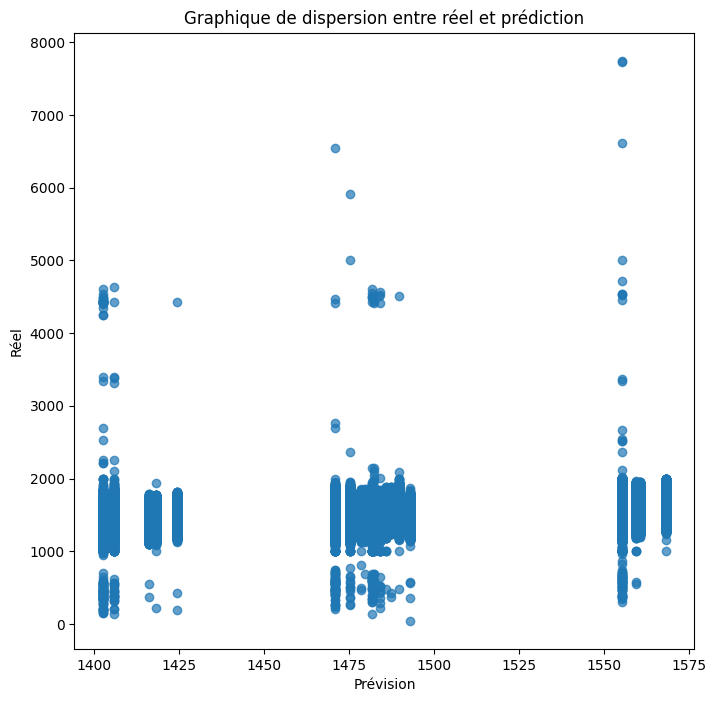

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Création d'un graphique de dispersion
predictions_and_labels = rf_predictions.select("prediction", "prix").rdd.map(lambda row: (float(row[0]), float(row[1])))
x, y = zip(*predictions_and_labels.collect())

plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.7)
plt.title("Graphique de dispersion entre réel et prédiction")
plt.xlabel("Prévision")
plt.ylabel("Réel")
plt.show()